In [1]:
import os
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import gammapy
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel
import subprocess
from pyirf.spectral import CRAB_MAGIC_JHEAP2015, PowerLaw, LogParabola
from pyirf.statistics import li_ma_significance
from scipy.stats import moyal, norm, skewnorm
from pathlib import Path

## Set cut efficiency

In [67]:
#
# Cut efficiency: the same for the gammaness cut and the theta cut
# Options: 0.4, 0.7, 0.9
#
# Recommended: 
# 0.7: standard cuts (safer for spectral analysis)
# 0.4: tight cuts, better for detection of weak sources
#
cut_efficiency = 0.4

## Load files which contain the (approximate) instrument response function, and show table contents
They characterize the average performance of LST1 within 1 degree off-axis (computed from diffuse gamma MC and
real data for the cosmic ray rates)
The Ereco/Etrue distributions in each Etrue bin is parametrized with moyal or a skewnorm function (whatever fits better) 

In [68]:
#
# Load files for the requested efficiency:
#
datadir = os.environ['LSTCHAIN'] + '/data/'

In [69]:
input_filename = datadir + f'LST1_gamma_irf_gheffi_{cut_efficiency:.2f}_theffi_{cut_efficiency:.2f}.csv'
gamma_data = pd.read_csv(input_filename)

input_filename = datadir + f'LST1_backg_irf_gheffi_{cut_efficiency:.2f}_theffi_{cut_efficiency:.2f}.csv'
background_data = pd.read_csv(input_filename)

In [70]:
gamma_data

,ZD_deg,Etrue_min_TeV,Etrue_max_TeV,Aeff_m2,emig_mu_loc,emig_mu_scale,emig_mu_a,emig_model
0,6.00,0.011220,0.014125,6.018636e+02,2.141614,0.237586,NaN,moyal
1,6.00,0.014125,0.017783,1.229892e+03,1.796029,0.218862,NaN,moyal
2,6.00,0.017783,0.022387,2.391636e+03,1.431809,0.201941,NaN,moyal
3,6.00,0.022387,0.028184,3.886893e+03,1.222006,0.185834,NaN,moyal
4,6.00,0.028184,0.035481,5.221963e+03,1.041203,0.175796,NaN,moyal
...,...,...,...,...,...,...,...,...
345,66.44,11.220185,14.125375,1.069989e+06,0.858829,0.174259,1.269968,skewnorm
346,66.44,14.125375,17.782794,1.139978e+06,0.844060,0.178565,1.444996,skewnorm
347,66.44,17.782794,22.387211,1.294651e+06,0.843795,0.182584,1.540402,skewnorm
348,66.44,22.387211,28.183829,1.192070e+06,0.848614,0.184290,1.672204,skewnorm


In [71]:
background_data

,ZD_deg,Ereco_min_TeV,Ereco_max_TeV,BckgRate_per_second,Theta_cut_deg,Gammaness_cut
0,6.00,0.012589,0.019953,0.085172,0.320000,0.149805
1,6.00,0.019953,0.031623,3.484274,0.254168,0.223265
2,6.00,0.031623,0.050119,4.478140,0.228366,0.242829
3,6.00,0.050119,0.079433,1.477260,0.179308,0.308257
4,6.00,0.079433,0.125893,0.127875,0.118691,0.520600
...,...,...,...,...,...,...
185,66.44,7.943282,12.589254,0.000170,0.100000,0.734576
186,66.44,12.589254,19.952623,0.000085,0.100000,0.755384
187,66.44,19.952623,31.622777,0.000043,0.100000,0.770523
188,66.44,31.622777,50.118723,0.000021,0.100000,0.791636


In [72]:
# CHECK that we have the same pointing zenith values in both tables:
assert np.alltrue(np.unique(gamma_data.ZD_deg) == np.unique(background_data.ZD_deg))

# Available zeniths:
zenith = np.unique(gamma_data.ZD_deg)
print('Available zeniths:', zenith, '(degrees)')

Available zeniths: [ 6.     9.579 16.08  23.16  30.39  37.66  44.92  52.16  59.34  66.44 ] (degrees)


##  Zenith distance bin selection

In [73]:
# Choose the bins among those above. Just set the bin number (from 0)
# Make sure you choose values which make sense for the declination of your source

zd_bin = 3

print('Selected ZD = ', zenith[zd_bin], 'degrees')

# Cuts for tables:
zd_selection_gamma = abs(gamma_data.ZD_deg - np.unique(gamma_data.ZD_deg)[zd_bin])<0.01
zd_selection_backg = abs(background_data.ZD_deg - np.unique(background_data.ZD_deg)[zd_bin])<0.01

Selected ZD =  23.16 degrees


## ON to OFF exposure

In [74]:
# Ratio of ON to OFF exposure (Li & Ma's "alpha")
# For standard wobble offset (0.4 deg) reasonable values are alpha=0.333 (3 off regions) above 0.2 TeV, 
# and alpha=1 below 0.2 TeV.  For testing sensitivity with the standard definition, set alpha=0.2

alpha = 0.333 # 1

## Pulsar mode
(overrides the setting of alpha above)

In [75]:
pulsar_mode = False # Set to True to activate it

on_phase_interval = 0.043 # Crab P1: [-0.017, 0.026] 
off_phase_interval = 0.35 # [0.52 - 0.87]

alpha = on_phase_interval / off_phase_interval
print(f'alpha = {alpha:.4f}')

# The spectrum is interpreted as average flux in full period (i.e. not just in the on-phase)

alpha = 0.1229


## Observation time

In [76]:
# effective_obs_time = 103 * u.h # Crab pulsar paper

# effective_obs_time = 8 * u.s # BOAT, 240 - 248 s

# effective_obs_time = 34 * u.h  # Crab nebula. performance paper

effective_obs_time = 11.8 * u.h  # 1ES 1011+496, February 2014 flare

## Source extension
For moderately extended sources, say below ~0.5 degrees radius
Set here the radius of the source within which (in 2d-gaussian approximation) the same fraction of the source is contained as the cut efficiency set above. That is, if you use 0.7 efficiency, set as source radius the angular distance within which 70% of the emission is expected to be contained.
We will simply increase the background by a factor (source_radius$^2$ + theta_cut$^2$) / (theta_cut$^2$), since we expect to integrate the same fraction of the signal within an angle sqrt(source_radius$^2$ + theta_cut$^2$) 

In [77]:
source_radius = 0 # 0.3 * u.deg
theta_cut = background_data.Theta_cut_deg[zd_selection_backg].to_numpy()*u.deg

if source_radius == 0:
    print("Emission from a point-like source will be assumed!")
    background_increase_factor = np.ones_like(theta_cut.to_value())
else:
    print(f'Source angular radius within which {cut_efficiency:.1%} of the emission is contained: {source_radius}')


    background_increase_factor = (theta_cut**2 + 
                                  (source_radius.to_value(u.deg)*np.ones_like(theta_cut))**2) / (theta_cut**2)

Emission from a point-like source will be assumed!


## Source redshift

In [78]:
redshift = 0

redshift = 0.212 # 1ES 1011
# redshift = 0.151 # BOAT GRB

# We will apply the Dominguez EBL model to simulate the absorption


# Make sure we have the necessary EBL absorption data:
try:
    os.environ['GAMMAPY_DATA']
except:
    # WE SET HERE THE GAMMAPY_DATA ENV VARIABLE IN CASE IT IS NOT SET
    gammapy_dir = Path(gammapy.__file__).parent
    gammapy_dir

    ebl_file = subprocess.run(['find', str(gammapy_dir), '-name', 'ebl_dominguez11.fits.gz'], 
                              stdout=subprocess.PIPE).stdout.decode()
    gammapy_data = ebl_file[:ebl_file.find('/ebl/')]
    os.environ['GAMMAPY_DATA'] = gammapy_data
    print('Set GAMMAPY_DATA to', gammapy_data)


dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

## Source (intrinsic) spectrum 

In [79]:
# Set here the simulated intrinsic spectrum intrinsic_dFdE
# (it must take as argument an astropy quantity with energy units!)

# Crab Nebula:
# def intrinsic_dFdE(E):
#     return CRAB_MAGIC_JHEAP2015(E)  # Crab Nebula, MAGIC log-parabola

# Crab pulsar P1, from LST1 paper (smoothly broken power-law):
# def intrinsic_dFdE(E):
#     return PowerLaw(normalization=1.27e-4 / (u.TeV * u.cm**2 * u.s), 
#                     index=-1.811, e_ref=1*u.GeV)(E) * (1+(E/(6.8*u.GeV))**((4.09-1.811)/3))**-3

# The BOAT (GRB 221009A) @ ~T0+240s: (set redshift above to 0.151)
# def intrinsic_dFdE(E):
#     return PowerLaw(normalization=208e-8 / (u.TeV * u.cm**2 * u.s),  
#                     index=-2.455, 
#                     e_ref=1*u.TeV)(E)


# 1ES1011 February 2014 flare
def intrinsic_dFdE(E):
    return PowerLaw(normalization=8.7e-10 / (u.TeV * u.cm**2 * u.s), 
                    index=-2.03, e_ref=0.25*u.TeV)(E)

# A log-parabola spectrum:
# def intrinsic_dFdE(E):
#     return LogParabola(normalization=5e-8 / (u.TeV * u.cm**2 * u.s), 
#                     a=-2, b =-0.05, 
#                     e_ref=0.1*u.TeV)(E)

In [80]:
# After EBL absorption:
def dFdE(E):
    return intrinsic_dFdE(E) * dominguez.evaluate(E, redshift, 1)

## END of user settings
#

In [81]:
# Other settings (change only for tests)

backg_systematics_uncertainty = 0.005 # 0.5% (relative) will be added in quadrature to statistical uncertainty of flux points 
min_signi_in_flux_point = 2     # minimum significance to display a flux point

integral_significance_threshold = 5  # "Detection significance"
integral_min_signal_to_backg_ratio = 0.05 # S/B must be larger or equal than this for detection

if pulsar_mode: # unbiased background can be taken from off-phase
    backg_systematics_uncertainty = 0
    integral_min_signal_to_backg_ratio = 0


min_Aeff = 100 *u.m**2         # Minimum required Aeff in Etrue bins. 
                               # Just to avoid Etrue bins with little MC stats, hence noisy!

# To exclude Ereco bins with too strong deviation of the true energies that fall inside them:
max_ereco_to_etrue_deviation = 0.5 #   abs(mean(Etrue)/ereco_bin_center - 1) < max_ereco_to_etrue_deviation

In [82]:
erecobins = background_data[zd_selection_backg].Ereco_min_TeV.to_numpy()
erecobins = np.append(erecobins, background_data[zd_selection_backg].Ereco_max_TeV.to_numpy()[-1])

In [83]:
etruebins = gamma_data[zd_selection_gamma].Etrue_min_TeV.to_numpy()
etruebins = np.append(etruebins, gamma_data[zd_selection_gamma].Etrue_max_TeV.to_numpy()[-1])

effective_area = gamma_data.Aeff_m2[zd_selection_gamma].to_numpy()*u.m**2

# Model to characterize the energy migration matrix (skewnorm or moyal):
emig_model = gamma_data[zd_selection_gamma].emig_model.to_numpy()

# Parameters to characterize the energy migration matrix:
loc = gamma_data[zd_selection_gamma].emig_mu_loc.to_numpy()
scale = gamma_data[zd_selection_gamma].emig_mu_scale.to_numpy()
a = gamma_data[zd_selection_gamma].emig_mu_a.to_numpy()


# Now we extrapolate Aeff to higher Etrue by using the same value of the highest available energy:
# (it is better than having zeros!) We also assume the same E-migration
factor = etruebins[-1]/etruebins[-2] # step in energy in each bin
while etruebins[-1] < 80: # extend to 80 TeV at least
    etruebins = np.append(etruebins, etruebins[-1]*factor)
    effective_area = np.append(effective_area, effective_area[-1])
    emig_model = np.append(emig_model, emig_model[-1])
    loc = np.append(loc, loc[-1])
    scale = np.append(scale, scale[-1])
    a = np.append(a, a[-1])

In [84]:
etruebincenters = (etruebins[:-1]*etruebins[1:])**0.5
erecobincenters = (erecobins[:-1]*erecobins[1:])**0.5

In [85]:
# Exclude too low eff. areas (in general, unreliable due to low MC stats)

effective_area[effective_area<min_Aeff] = 0

# Exclude also Ereco bins which have Ereco values below the first Etrue value with valid Aeff:
ereco_mask = erecobincenters >= etruebincenters[np.where(effective_area>0)[0][0]]

In [86]:
# Integrate dF/dE within a bin, assuming power-law approximation within it:
def integrate (dfde1, dfde2, e1, e2):
    # We cannot let numpy deal with the units, sometimes rounding leads to wrong units in result!
    # like TeV^(1e-15) :-D
    if (dfde1 == 0) | (dfde2 == 0): # May happen, e.g because of EBL or a strong cutoff
        return 0
    
    # In power-law approximation:
    gamma = np.log(dfde2/dfde1) / np.log(e2/e1)
    e1tev = e1.to_value(u.TeV)
    e2tev = e2.to_value(u.TeV)
    
    integral = (dfde1.to_value(1/(u.TeV * u.cm**2 * u.s)) / 
                (gamma+1) * e1tev**(-gamma) * 
                (e2tev**(gamma+1) - e1tev**(gamma+1))
               )
    return integral # (1/u.s/u.cm**2)

In [87]:
integrated_flux = []
for etruemin, etruemax in zip(etruebins[:-1], etruebins[1:]):
    integrated_flux.append(integrate(dFdE(etruemin*u.TeV),
                                     dFdE(etruemax*u.TeV),
                                     etruemin*u.TeV, 
                                     etruemax*u.TeV))
integrated_flux = np.array(integrated_flux)

# Too strong EBL absorption produces NaNs in high-E bins, jus trplace by 0's:
integrated_flux[np.isnan(integrated_flux)] = 0
    
integrated_flux = np.array(integrated_flux) * 1/(u.s * u.cm**2)

## Effective area

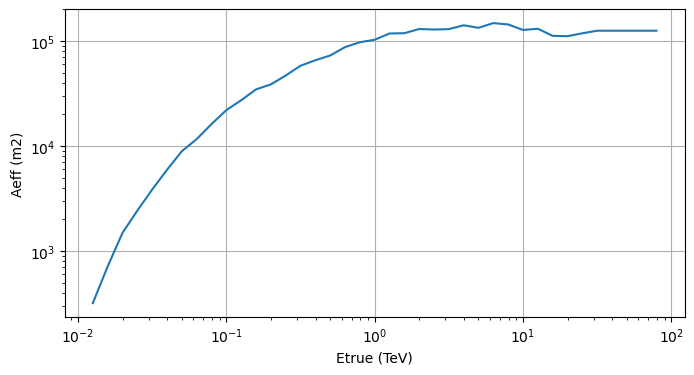

In [88]:
plt.figure(figsize=(8,4))
plt.plot(etruebincenters, effective_area)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Etrue (TeV)')
plt.ylabel('Aeff (m2)')
plt.grid()

## Background rate

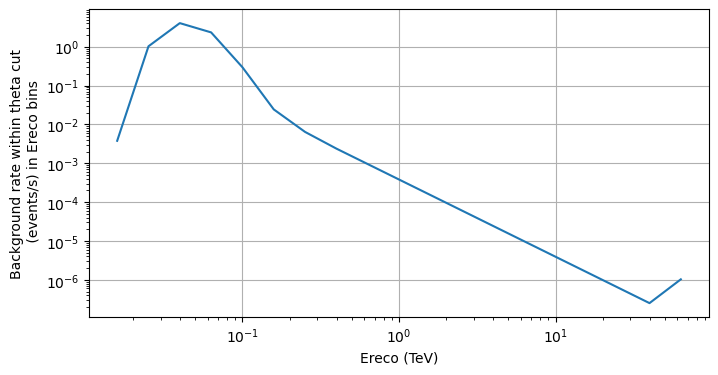

In [89]:
plt.figure(figsize=(8,4))

bgrate = background_data[zd_selection_backg].BckgRate_per_second.to_numpy()

if pulsar_mode: # Scale background to the on-phase:
    bgrate *= on_phase_interval

bgrate *= background_increase_factor

plt.plot(erecobincenters[ereco_mask], bgrate[ereco_mask])
plt.xlabel('Ereco (TeV)')
plt.ylabel('Background rate within theta cut\n (events/s) in Ereco bins')
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [90]:
total_gamma_rate = (integrated_flux*effective_area).to(1/u.s)
print(f'Total gamma rate after cuts: {total_gamma_rate.sum().to_value(1/u.s):.3f} events/s')

Total gamma rate after cuts: 0.286 events/s


In [91]:
num_realizations_a = 100
num_realizations_b = 100
# Number of realizations (random numbers taken from skewnorm or moyal) for E-migration simulation

num_realizations = num_realizations_a * num_realizations_b

In [92]:
fine_etrue_binning = np.logspace(-2.5, 3.5, 601) # Just for calculation of mean Etrue within an Ereco bin

total_bg_counts = effective_obs_time.to_value(u.s) * bgrate

total_signal_counts_2d = np.zeros(shape=[len(total_bg_counts), len(fine_etrue_binning)-1])

for ietrue in range(len(etruebincenters)):
    
    gamma_rate = total_gamma_rate[ietrue]

    
    emin= etruebins[ietrue]
    emax = etruebins[ietrue+1]

    etrue_values = np.exp(np.log(emin) + np.log(emax/emin) * np.random.uniform(0, 1, num_realizations_a))
    
    for etrue in etrue_values:
        # print(f'{ietrue}: {etrue:.4f} TeV, {gamma_rate}, {loc[ietrue]:.4f}, {scale[ietrue]:.4f}, {emig_model[ietrue]}')
        # Possible alternative: simulate according to the (interpolated) events vs Etrue graph,
        # instead of all energies being equal to the bin center

        if emig_model[ietrue] == 'skewnorm':
            ereco = etrue*skewnorm.rvs(a[ietrue], loc[ietrue], scale[ietrue], 
                                           num_realizations_b)                  
        elif emig_model[ietrue] == 'moyal':
            ereco = etrue*moyal.rvs(loc[ietrue], scale[ietrue], 
                                    num_realizations_b)
        else:
            continue

        # counts, _ = np.histogram(ereco, bins=erecobins)
        # Histogram in very fine Etrue bins, for later calculation of mean true energy of
        # gammas within each Ereco bin:
        counts, _, _ = np.histogram2d(ereco, etrue*np.ones_like(ereco), bins=[erecobins, fine_etrue_binning]) 


        # Integrate in Ereco bins and add to total:
        total_signal_counts_2d += (gamma_rate * effective_obs_time * counts / num_realizations)

        
total_signal_counts = np.sum(total_signal_counts_2d, axis=1) # Integrate in Ereco bins
# Now set to zero values below the "reliable minimum energy":
total_signal_counts[~ereco_mask] = 0
total_bg_counts[~ereco_mask] = 0
 

(0.1, 345586.71542930865)

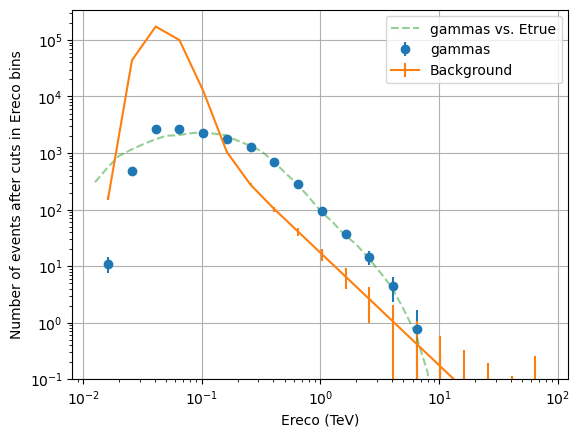

In [93]:
plt.errorbar(0.5*(erecobins[:-1]+erecobins[1:]), total_signal_counts, total_signal_counts**0.5,
             label='gammas', fmt='o')
plt.errorbar(0.5*(erecobins[:-1]+erecobins[1:]), total_bg_counts, total_bg_counts**0.5,
             label='Background')

# PLOT GAMMAS VS. ETRUE FOR COMPARISON, correcting for the different bin width:
plt.plot(etruebincenters, total_gamma_rate*effective_obs_time.to_value(u.s)*
         len(etruebincenters)/len(erecobincenters), '--', alpha=0.5, label='gammas vs. Etrue')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Number of events after cuts in Ereco bins')
plt.grid()
plt.ylim(0.1, 2*max(np.max(total_bg_counts), np.max(total_signal_counts)))


In [94]:
total_bg_counts

array([1.61414955e+02, 4.37676163e+04, 1.72793358e+05, 9.97278449e+04,
       1.26368420e+04, 1.03932861e+03, 2.73475801e+02, 1.01725507e+02,
       4.07068517e+01, 1.62894029e+01, 6.51842715e+00, 2.60843769e+00,
       1.04380198e+00, 4.17691626e-01, 1.67145012e-01, 6.68853602e-02,
       2.67650908e-02, 1.07104168e-02, 4.38877140e-02])

In [95]:
mean_etrue_vs_ereco = np.zeros_like(erecobincenters)
finebincenters = 0.5 * (fine_etrue_binning[1:]+fine_etrue_binning[:-1])

for iereco in range(len(erecobincenters)):
    if np.nansum(total_signal_counts_2d[iereco]) == 0:
        continue
    mean_etrue_vs_ereco[iereco] = (np.nansum(finebincenters * total_signal_counts_2d[iereco]) / 
                                   np.nansum(total_signal_counts_2d[iereco]))

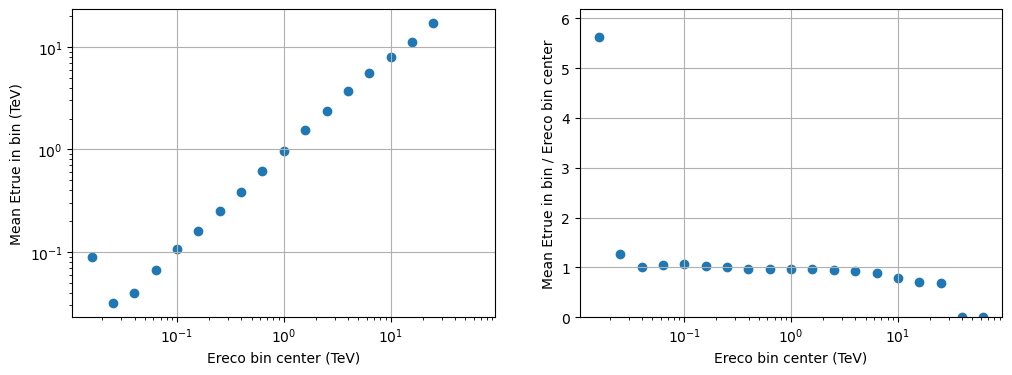

In [96]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(1, 2, 1)
plt.scatter(erecobincenters, mean_etrue_vs_ereco)
plt.xlabel('Ereco bin center (TeV)')
plt.ylabel('Mean Etrue in bin (TeV)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

fig.add_subplot(1, 2, 2)
plt.scatter(erecobincenters, mean_etrue_vs_ereco / erecobincenters)
plt.xlabel('Ereco bin center (TeV)')
plt.ylabel('Mean Etrue in bin / Ereco bin center')
plt.ylim(0, 1.1*np.nanmax(mean_etrue_vs_ereco/erecobincenters))
plt.xscale('log')
plt.grid()

plt.show()

In [97]:
# Let's not use bind with too high bias in the spectrum:
not_too_high_bias = abs(mean_etrue_vs_ereco / erecobincenters - 1) < max_ereco_to_etrue_deviation

In [98]:
significance = li_ma_significance(total_signal_counts+total_bg_counts,
                                  total_bg_counts/alpha, alpha)

# integrating from each Ereco to max Ereco
integral_signal_counts = np.cumsum(total_signal_counts[::-1])[::-1]
integral_bg_counts = np.cumsum(total_bg_counts[::-1])[::-1]

integral_significance = li_ma_significance(integral_signal_counts+integral_bg_counts,
                                           integral_bg_counts/alpha, alpha)
integral_signal_to_background_ratio = integral_signal_counts / integral_bg_counts

## Signal to background ratio and significance in Ereco bins

In [99]:
signal_to_background_ratio = total_signal_counts / total_bg_counts

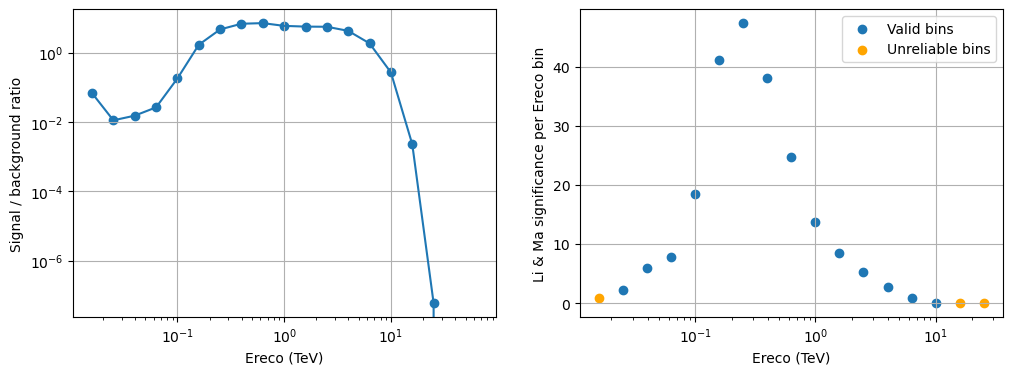

In [100]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(1, 2, 1)
plt.plot(erecobincenters, signal_to_background_ratio)
plt.scatter(erecobincenters, signal_to_background_ratio)
plt.grid()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Signal / background ratio')
plt.yscale('log')
plt.xscale('log')

fig.add_subplot(1, 2, 2)

# Conditions to consider a bin reliable
reliable_points = ((signal_to_background_ratio >= backg_systematics_uncertainty) &
                   not_too_high_bias)

plt.scatter(erecobincenters[reliable_points], significance[reliable_points], 
            label='Valid bins')

plt.scatter(erecobincenters[~reliable_points], significance[~reliable_points], label='Unreliable bins', color='orange')

plt.grid()
plt.legend()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Li & Ma significance per Ereco bin')
plt.xscale('log')

## Integral significance (for Ereco>xx)

*************************
Detection successful! :-D


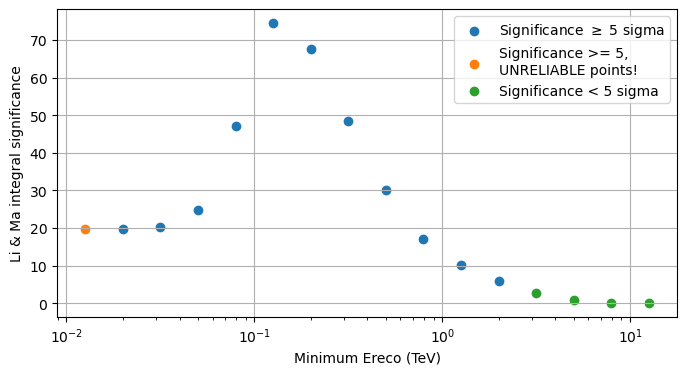

In [101]:
plt.figure(figsize=(8,4))

mask = (integral_significance >= integral_significance_threshold)

plt.scatter(erecobins[:-1][mask & reliable_points], integral_significance[mask & reliable_points], 
            label=f'Significance $\geq$ {integral_significance_threshold} sigma')

if (mask & ~reliable_points).sum() > 0:
    plt.scatter(erecobins[:-1][mask & ~reliable_points], integral_significance[mask & ~reliable_points], 
                label=f'Significance >= {integral_significance_threshold}, \nUNRELIABLE points!')

plt.scatter(erecobins[:-1][~mask], integral_significance[~mask],
            label=f'Significance < {integral_significance_threshold} sigma')
plt.grid()
plt.xlabel('Minimum Ereco (TeV)')
plt.ylabel('Li & Ma integral significance')
plt.xscale('log')

if (mask & reliable_points).sum() > 0:
    print('*************************')
    print('Detection successful! :-D')
else:
    print('****************')
    print('No detection :-C')
plt.legend()
plt.show()

## Simulated SED from observation (Asimov dataset)
The fluxes & uncertainties are computed in the Ereco bins, then placed at the mean Etrue of the gamma events falling within the bin, and at the "expected" flux level. 
In reality proper energy unfolding will be needed... what is shown below is just a an estimate of what the spectrum will look like - but pretty accurate for the purpose of observation planning.

In [102]:
noff = total_bg_counts / alpha
non = total_signal_counts + total_bg_counts
# excess = non - alpha * noff (= total_signal_counts in Asimov dataset)
stat_excess_error = (non + alpha**2 * noff)**0.5

np.seterr(divide='ignore')
relative_stat_excess_error = stat_excess_error/total_signal_counts

syst_excess_error = backg_systematics_uncertainty * total_bg_counts

relative_syst_excess_error = syst_excess_error / total_signal_counts
total_relative_excess_error = np.hypot(relative_stat_excess_error, relative_syst_excess_error)

In [ ]:
displayed_points = reliable_points & (significance > min_signi_in_flux_point)

if displayed_points.sum() > 0:

    SED = ((mean_etrue_vs_ereco[displayed_points]*u.TeV)**2 * 
           dFdE(mean_etrue_vs_ereco[displayed_points]*u.TeV))

    SED_stat_error = SED*relative_stat_excess_error[displayed_points]
    SED_total_error = SED*total_relative_excess_error[displayed_points]

    plt.figure(figsize=(8,4))
    intrinsic_SED = (finebincenters*u.TeV)**2 * intrinsic_dFdE(finebincenters*u.TeV)

    if redshift > 0:
        plt.plot(finebincenters, intrinsic_SED, '--', color='lightgrey', label='intrinsic')


    SED_fine = (fine_etrue_binning*u.TeV)**2 * dFdE(fine_etrue_binning*u.TeV)
    plt.plot(fine_etrue_binning, SED_fine, '--')


    if not pulsar_mode:
        plt.errorbar(mean_etrue_vs_ereco[displayed_points], SED, yerr=SED_total_error, 
                     fmt='o', markersize=2, 
                     label='Observed, stat+syst')
    plt.errorbar(mean_etrue_vs_ereco[displayed_points], SED, yerr=SED_stat_error, 
                 fmt='o', markersize=2, 
                 label='Observed, stat-only')

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy (TeV)')
    plt.ylabel(f'SED ({SED.unit})')
    plt.ylim(np.nanmin((SED-SED_total_error)).value*0.1, 
             np.nanmax((SED+SED_total_error)).value*5)

    plt.xlim(mean_etrue_vs_ereco[displayed_points][0]/3, mean_etrue_vs_ereco[displayed_points][-1]*3)
    plt.legend()
    plt.grid()
    
else:
    print("Nothing to display. No valid flux points!")